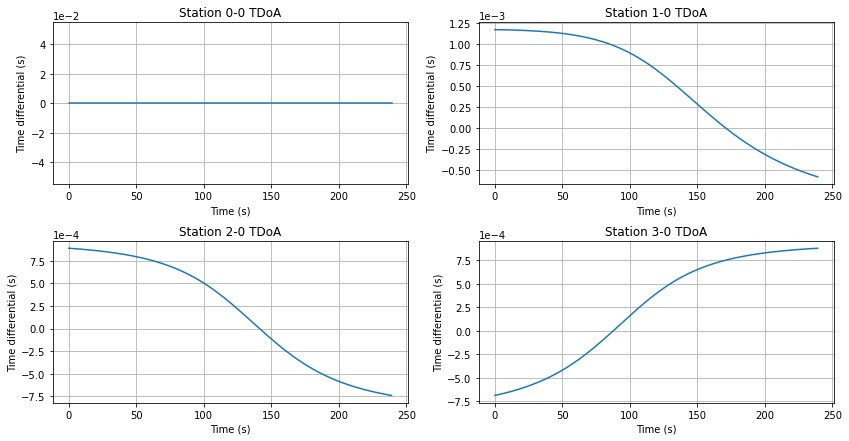

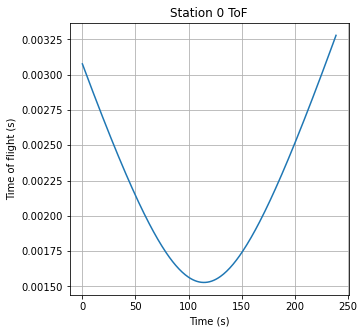

In [1]:
import time
import numpy as np
import argparse
import os

from astropy.time import Time   # Astropy 4.1rc1 is used

from orbdet.utils.utils import *
from orbdet.utils.utils_aux import *
from orbdet.utils.utils_vis import *

from scipy.optimize import fsolve

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=4)

n_obs = 4

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=3, frame='teme')
tdoa, tof = get_tdoa_simulated(x_sat_orbdyn_stm, x_obs_multiple)
r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)

fig_1 = plt.figure(figsize=(14,7))

for i in range(n_obs):
    ax = fig_1.add_subplot(2, 2, i+1)
    ax.plot(t_sec, tdoa[i,:])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Time differential (s)')
    ax.grid(':')
    ax.title.set_text(f"Station {i}-0 TDoA")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig_1.subplots_adjust(hspace=0.35)

fig_2 = plt.figure(figsize=(5,5))

ax = fig_2.add_subplot(1, 1, 1)
ax.plot(t_sec, tof[0,:])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time of flight (s)')
ax.grid(':')
ax.title.set_text(f"Station 0 ToF")

In [31]:

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=3, frame='teme')
tdoa, tof = get_tdoa_simulated(x_sat_orbdyn_stm, x_obs_multiple)
r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)

idx = 0
x_sat = np.expand_dims(x_sat_orbdyn_stm[0:3, idx], axis=1)
x_obs = x_obs_multiple[0:3, idx, :]

print(x_obs)

x_obs_mean = np.mean(x_obs, axis=1)

vars_0  = [x_sat.item(0)+50000, x_sat.item(1)+50000, x_sat.item(2)+50000, 1]
vars_0  = [x_obs_mean[0]*1.0, x_obs_mean[1]*1.0, x_obs_mean[2]*1.0, 1]

vars_gt = [x_sat.item(0), x_sat.item(1), x_sat.item(2), r[0,idx]/C]
data    = (x_obs, tdoa[:, idx])

a = tdoa_objective_function(vars_0, *data)

result = fsolve(tdoa_objective_function, vars_0, args=data)

print(f"Initial: \t{np.array(vars_0)}")
print(f"Groundtruth: \t{np.array(vars_gt)}, Norm: \t{np.linalg.norm(vars_gt)}")
print(f"Result: \t{result}, Norm: \t{np.linalg.norm(result)}")
print(f"Difference:\t{result - vars_gt}, Norm: \t{np.linalg.norm(result - vars_gt)}")




[[-4924093.9905 -5198359.6016 -4948126.1049 -4695228.4547]
 [ 1980475.7938  1824128.2016  1654940.7112  2127140.5391]
 [ 3525839.1213  3203491.761   3656368.1419  3744000.6675]]
Initial: 	[-4.9415e+06  1.8967e+06  3.5324e+06  1.0000e+00]
Groundtruth: 	[-4.8286e+06  2.8069e+06  3.9237e+06  3.0761e-03], Norm: 	6825622.576372675
Result: 	[-4.3555e+06  2.4475e+06  3.4933e+06  2.4569e-03], Norm: 	6096162.596750522
Difference:	[ 4.7311e+05 -3.5944e+05 -4.3040e+05 -6.1920e-04], Norm: 	733669.1476238151


(6, 240, 4)


Text(-4355470.396697515, 2447502.4428073405, 'Result')

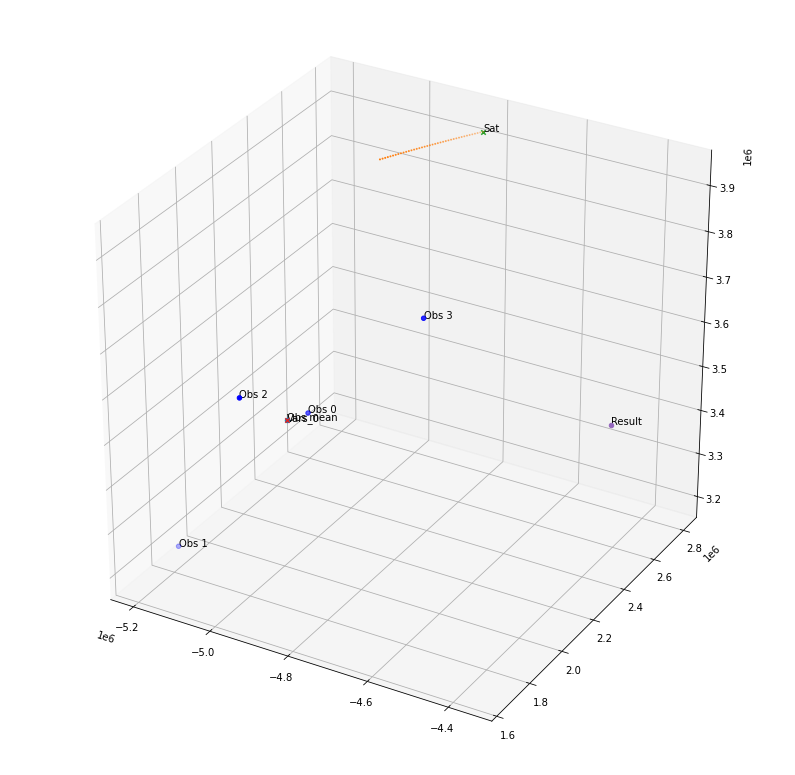

In [32]:
fig = plt.figure(figsize=(14,14))

print(x_obs_multiple.shape)

ax = fig.add_subplot(111, projection='3d')

#plot_sphere(ax, d=R_EQ, n=40)
# Observer
obs = ax.scatter(x_obs_multiple[0,idx,:], x_obs_multiple[1,idx,:], x_obs_multiple[2,idx,:], marker='o', c='b')
for i in range(x_obs_multiple.shape[2]):
    ax.text(x_obs_multiple[0,idx,i], x_obs_multiple[1,idx,i], x_obs_multiple[2,idx,i], f"Obs {i}")
# Mean observer position
obs_mean = ax.scatter(x_obs_mean[0], x_obs_mean[1], x_obs_mean[2], marker='o')
ax.text(x_obs_mean[0], x_obs_mean[1], x_obs_mean[2], f"Obs mean")

# Satellite
sat = ax.scatter(x_sat_orbdyn_stm[0,:40], x_sat_orbdyn_stm[1,:40], x_sat_orbdyn_stm[2,:40], s=1)
sat_0 = ax.scatter(x_sat_orbdyn_stm[0,0], x_sat_orbdyn_stm[1,0], x_sat_orbdyn_stm[2,0], marker='x')
ax.text(x_sat_orbdyn_stm[0,0], x_sat_orbdyn_stm[1,0], x_sat_orbdyn_stm[2,0], "Sat")

# Initial position
ax.scatter(vars_0[0], vars_0[1], vars_0[2], marker='x')
ax.text(vars_0[0], vars_0[1], vars_0[2], f"Vars_0")

# Result 
ax.scatter(result[0], result[1], result[2], marker='o')
ax.text(result[0], result[1], result[2], f"Result")


